# Political Survey Clustering Analysis

#### **Goal:** Take survey data and perform basic statistics and clustering analyses to observe differences between self-identified political groups.
**Date:** October 2023<br>
**Notebook Author(s)**: Ike Silver, Rahim Hashim<br>
**Data Owner(s)**: Ike Silver

## Import / Install Packages
Run the below line to mount Google Drive, where this notebook and the underlying `.xlsx` dataset should be.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
# set max pandas columns to display
pd.set_option('display.max_columns', None)
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
os.chdir('/content/drive/MyDrive/Time Bioventures/Projects/White Papers/Drug Development/FDA-NCE-Scraper')

In [14]:
import os
import re
import sys
import time
import tqdm
import string
import datetime
import requests
import textwrap
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from collections import defaultdict
# turn off lxml warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# pubchempy is a Python wrapper for the PubChem PUG REST API
!pip install pubchempy
import pubchempy as pcp
# pytrials is a Python wrapper for the ClinicalTrials.gov API
!pip install pytrials
from pytrials.client import ClinicalTrials
# custom functions
from utils.fda_sponsors import fda_sponsor_list, rename_sponsors
from utils.webpage_scraping import test_connection
from utils.text_search import find_drug, find_df_overlap, combine_ddc_databases
from utils.pickle_dataframes import pickle_dataframe, unpickle_dataframes, read_excel
# auto reload custom functions
%load_ext autoreload
%autoreload 2
# other settings
sys.setrecursionlimit(10000) # increase recursion limit for pickle

***
## Convert Excel to DataFrame
It will be easiest to observe/analyze the dataset once it's in a pandas DataFrame format. Update the `EXCEL_PATH` variable on the right by finding where the dataset is saved in your Google Drive. You can do so by clicking on the folder icon on the left panel, going to `drive`, navigating to the file, and copy-pasting it in the field to the right.

In [16]:
# saved excel with fda-approved drugs
excel_path = os.getcwd()
fda_drug_df = read_excel(excel_path)
# unpickle all saved dataframes
df_dict = unpickle_dataframes(database_folder='databases')
# https://www.accessdata.fda.gov/scripts/cder/daf/index.cfm
fda_approved_df = df_dict['fda_approved_df']
# https://www.fda.gov/vaccines-blood-biologics/development-approval-process-cber/biological-approvals-year
fda_biologics_df = df_dict['fda_biologics_df']
# https://open.fda.gov/apis/drug/ndc/
fda_api_df = df_dict['fda_api_df']
# www.drugs.com drugs
ddc_drugs = df_dict['ddc_drugs'].sort_values(by=['drug_name']).reset_index(drop=True)
# www.drugs.com drug classes
ddc_drug_classes = df_dict['ddc_drug_classes'].sort_values(by=['drug_name']).reset_index(drop=True)
ddc_df = combine_ddc_databases(ddc_drugs, ddc_drug_classes)
# www.clinicaltrials.gov
ct_gov_df = df_dict['ctgov_df']
# www.dailymed.nlm.nih.gov
dailymed_df = df_dict['dailymed_df']
# www.pubchem.ncbi.nlm.nih.gov

FDA NCE df shape: (542, 23)
Number of pickled files found: 8
  ctgov_df dataframe shape: (46051, 32)
  dailymed_df dataframe shape: (259393, 6)
  ddc_drug_classes dataframe shape: (8093, 20)
  ddc_drugs dataframe shape: (1239, 13)
  fda_api_df dataframe shape: (542, 88)
  fda_approved_df dataframe shape: (28291, 7)
  fda_biologics_df dataframe shape: (469, 11)
  pubchem_df dataframe shape: (541, 8)
Finding overlap between drug_name in two dataframes...
 Number of drugs in df_1: 1239
 Number of drugs in df_2: 7276
 Number of drugs from df_1 in df_2: 740
  df_1 drugs missing in df_2: ['bisoprolol', 'folic acid', 'chlorthalidone', 'simvastatin', 'felodipine', 'lacosamide', 'verapamil', 'loratadine', 'hydrochlorothiazide and losartan', 'levothyroxine']...
 Number of drugs from df_2 in df_1: 1138
  df_2 drugs missing in df_1: ['atropen', 'isopto atropine', 'pombiliti', 'vividsensiguard', 'ameluz', 'alka-seltzer plus cold formula sparkling original effervescent tablets', 'aprodine', 'femcon 

Delete any rows that have missing datasets.

In [73]:
len([indication for indication in df['pharm_class_cs'].tolist() if indication])+len([indication for indication in df['pharm_class_cs'].tolist() if not indication])

542

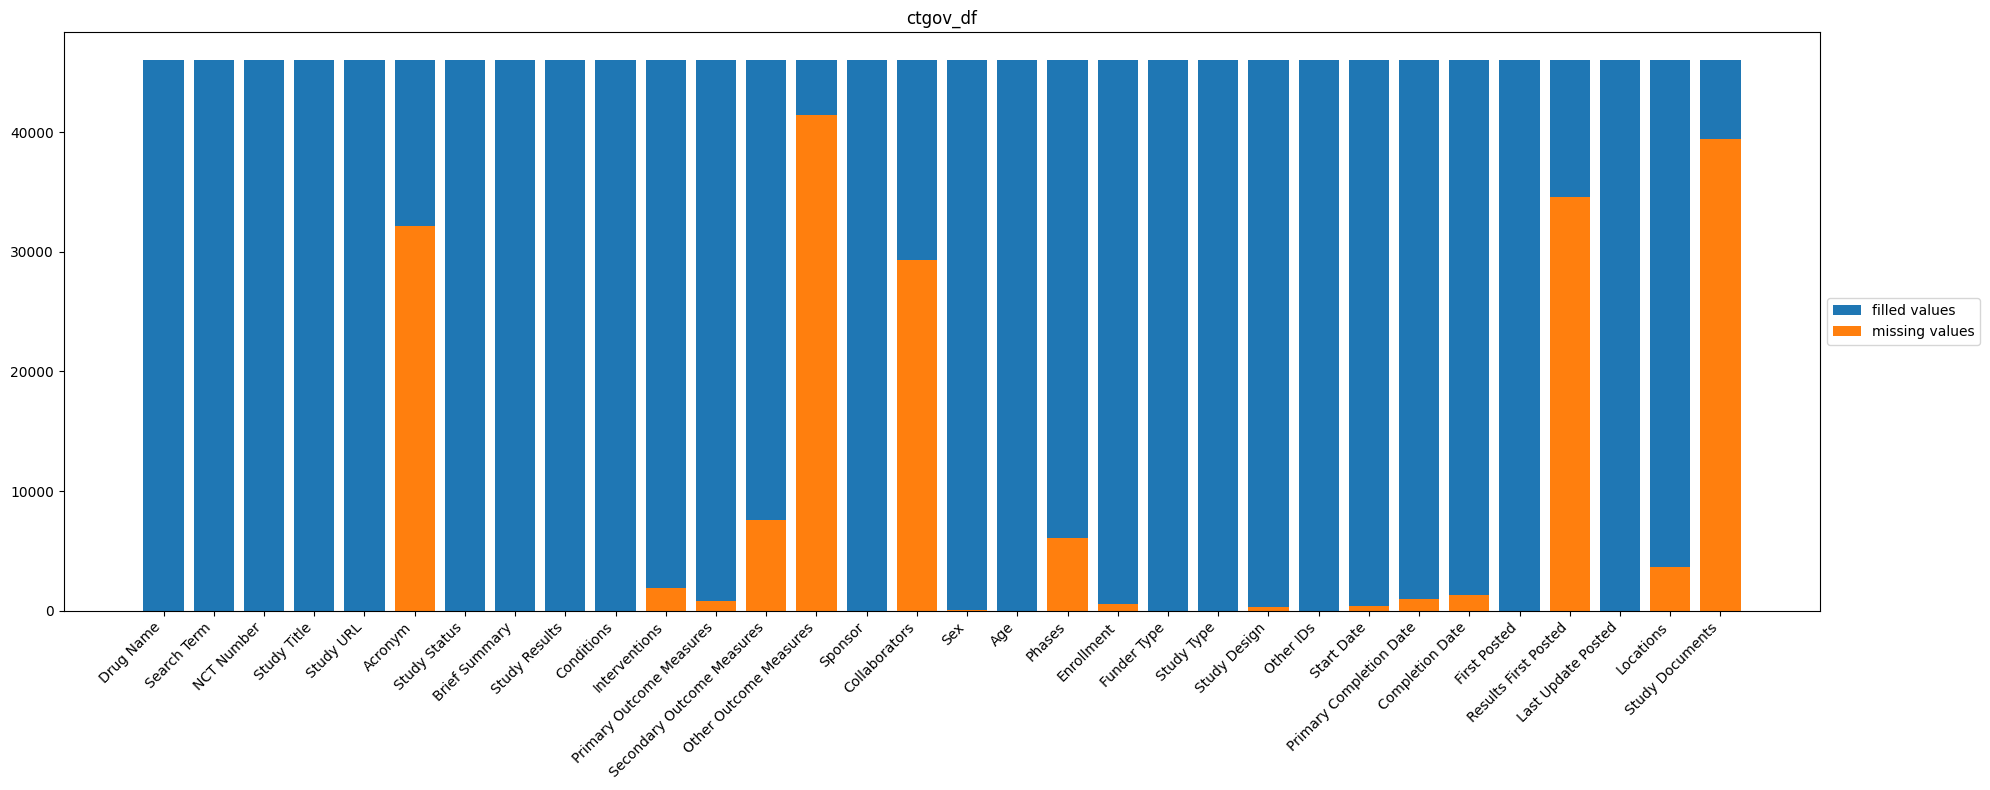

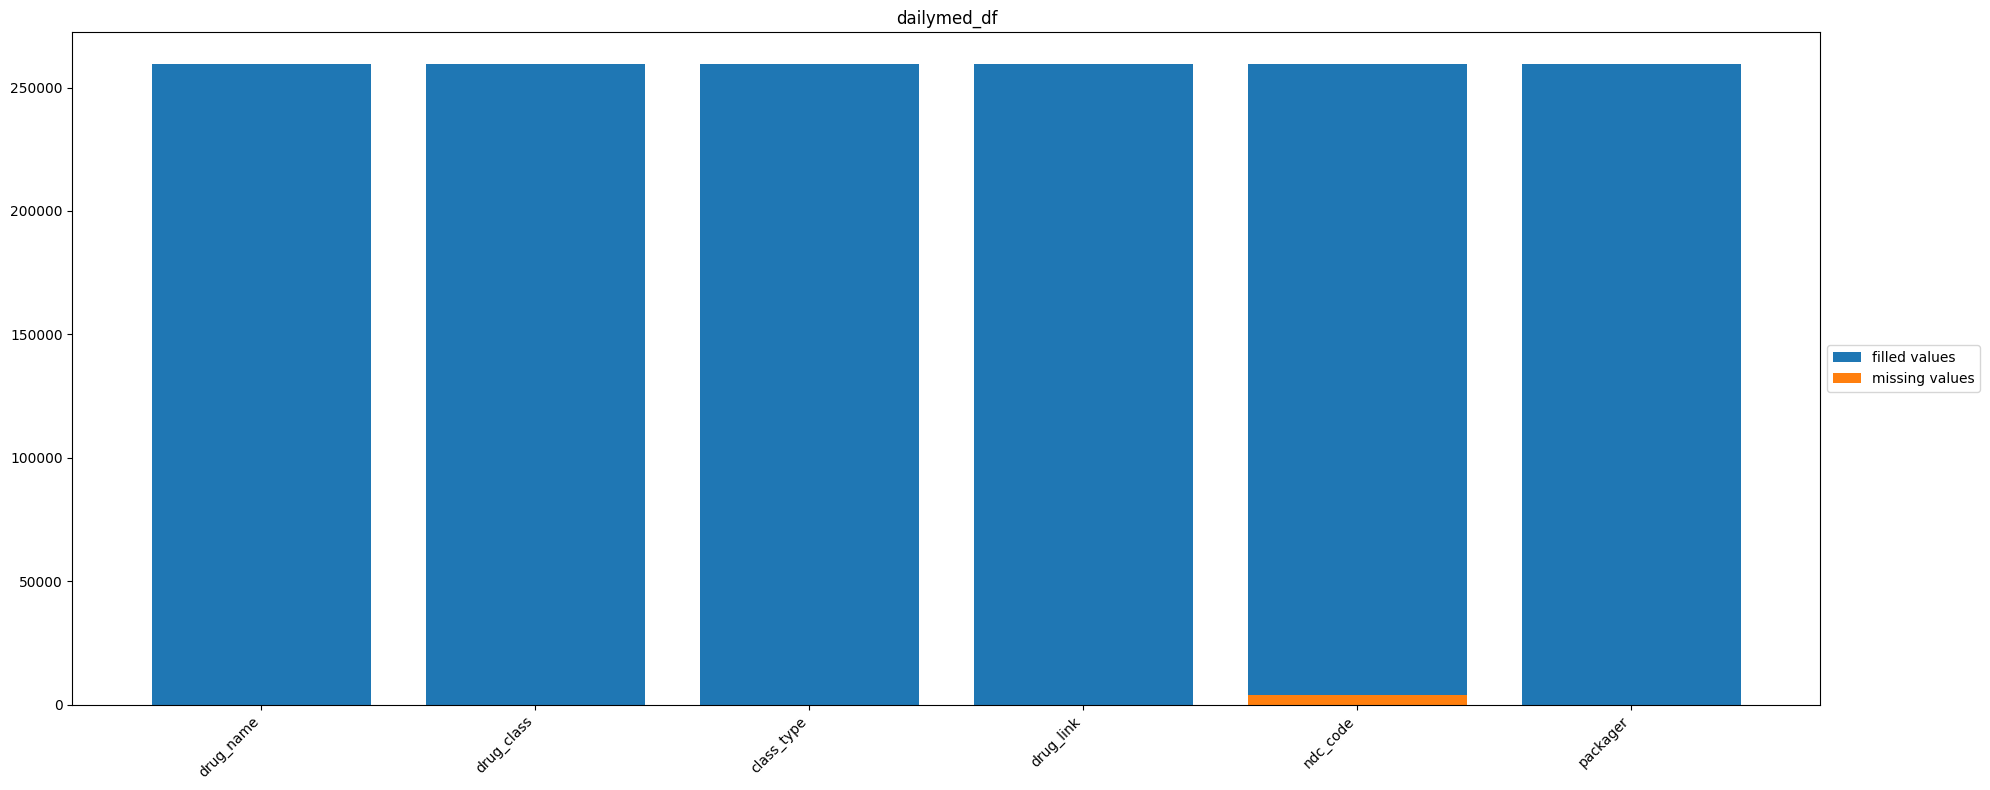

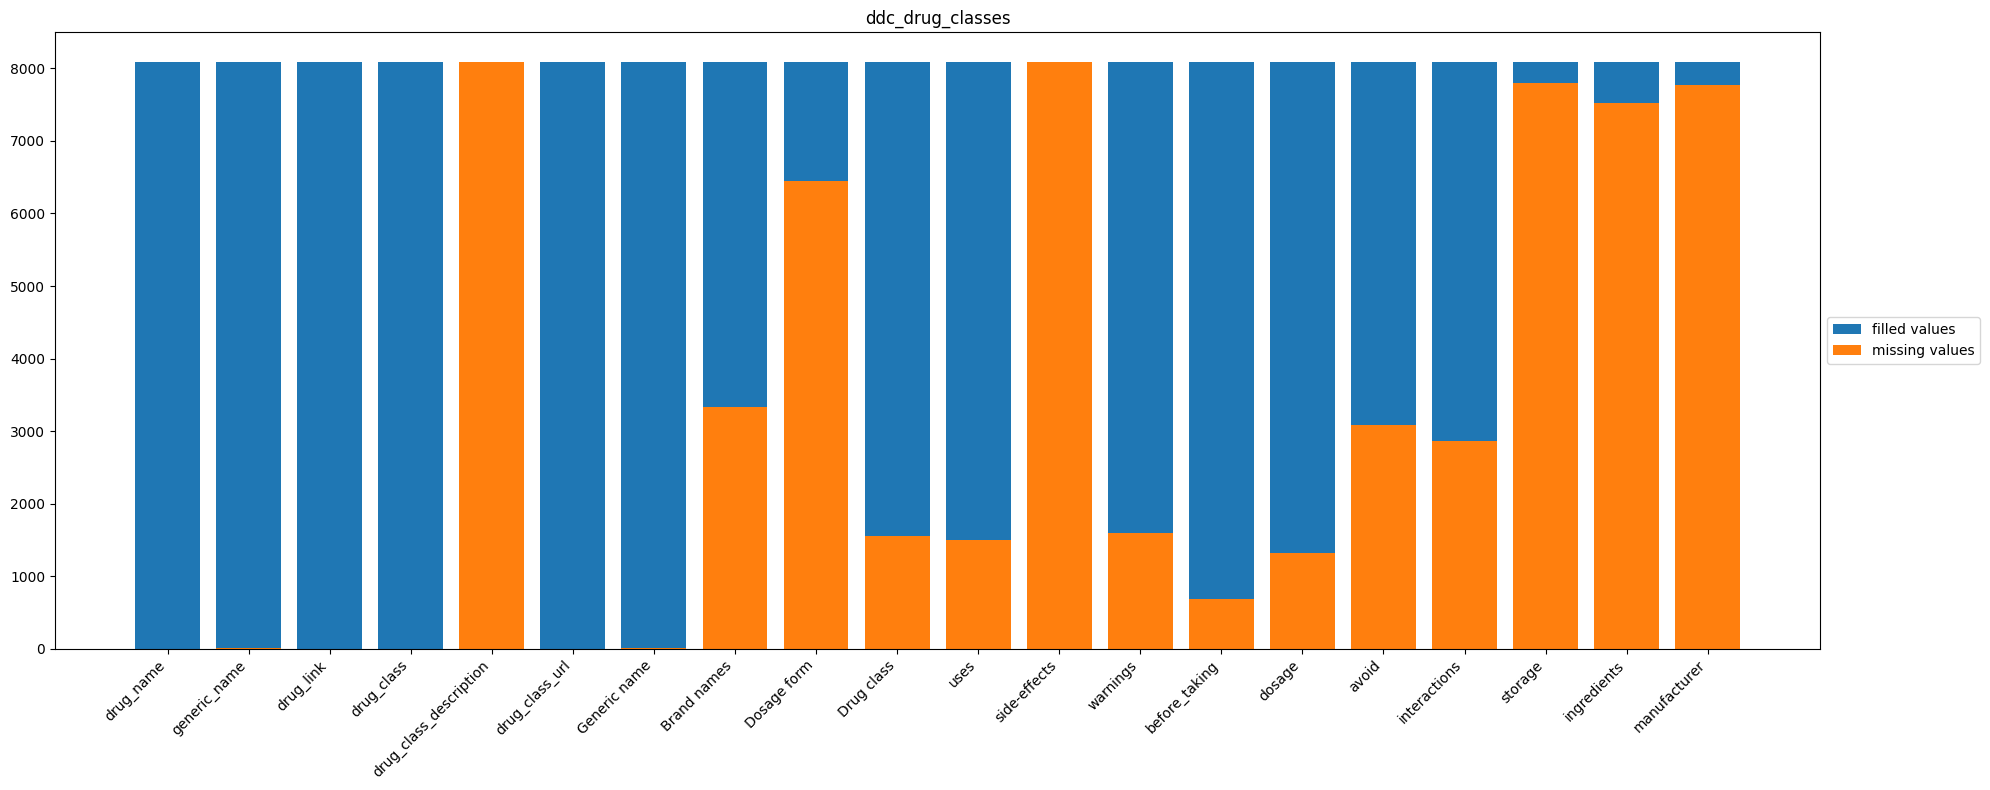

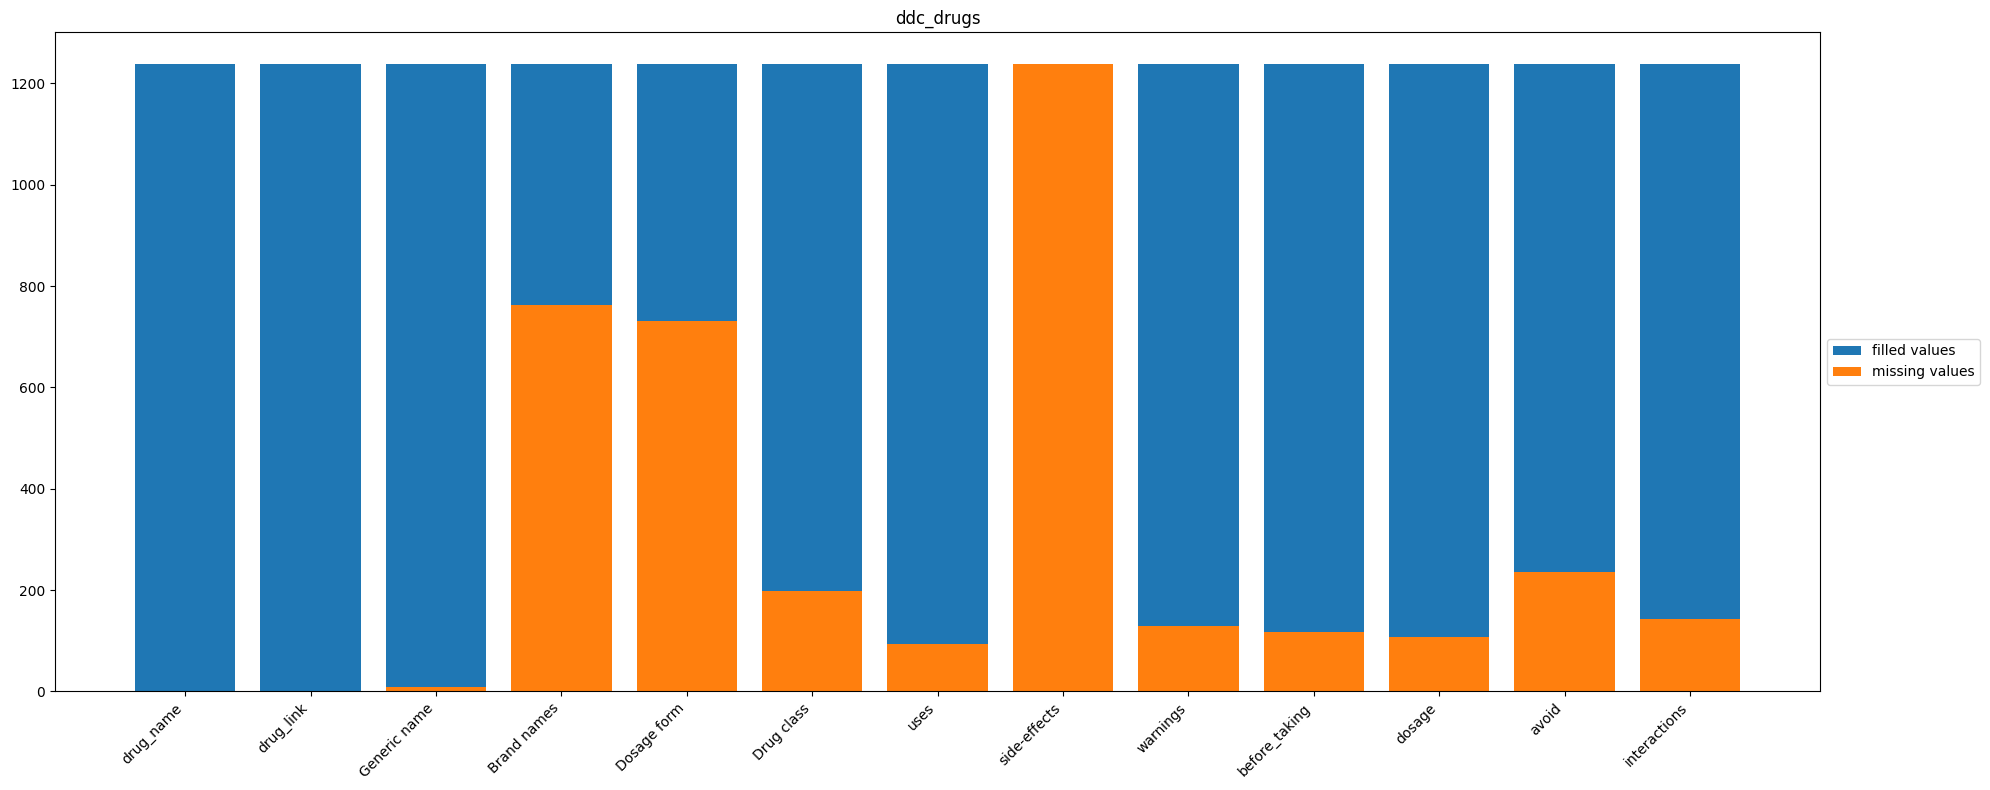

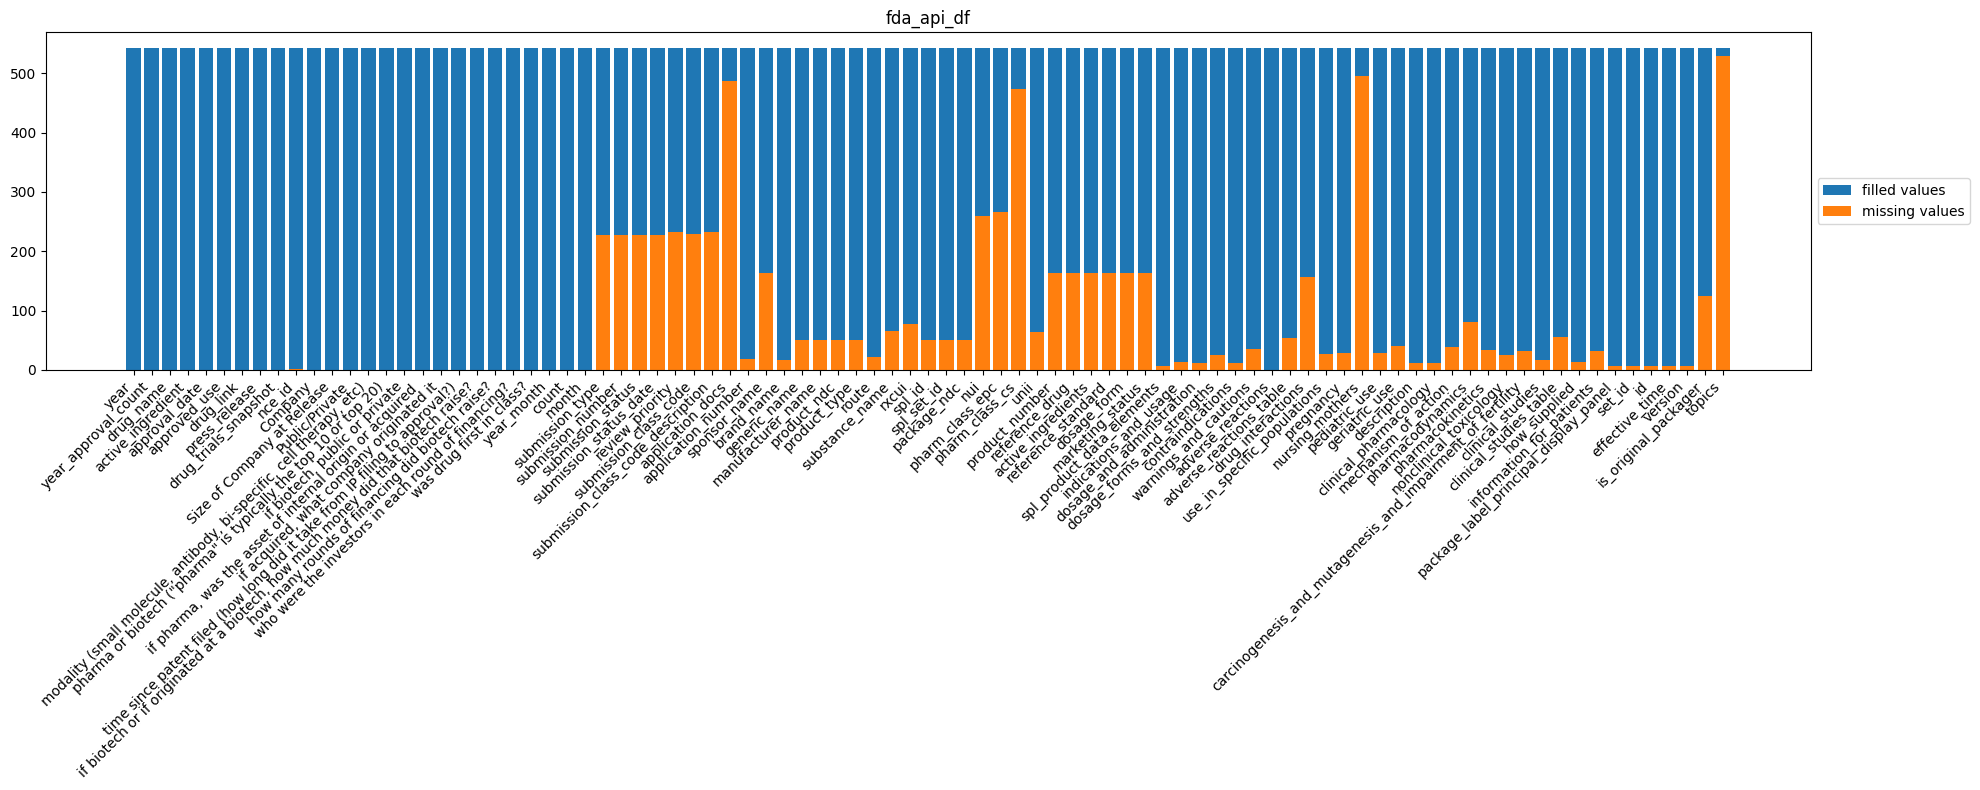

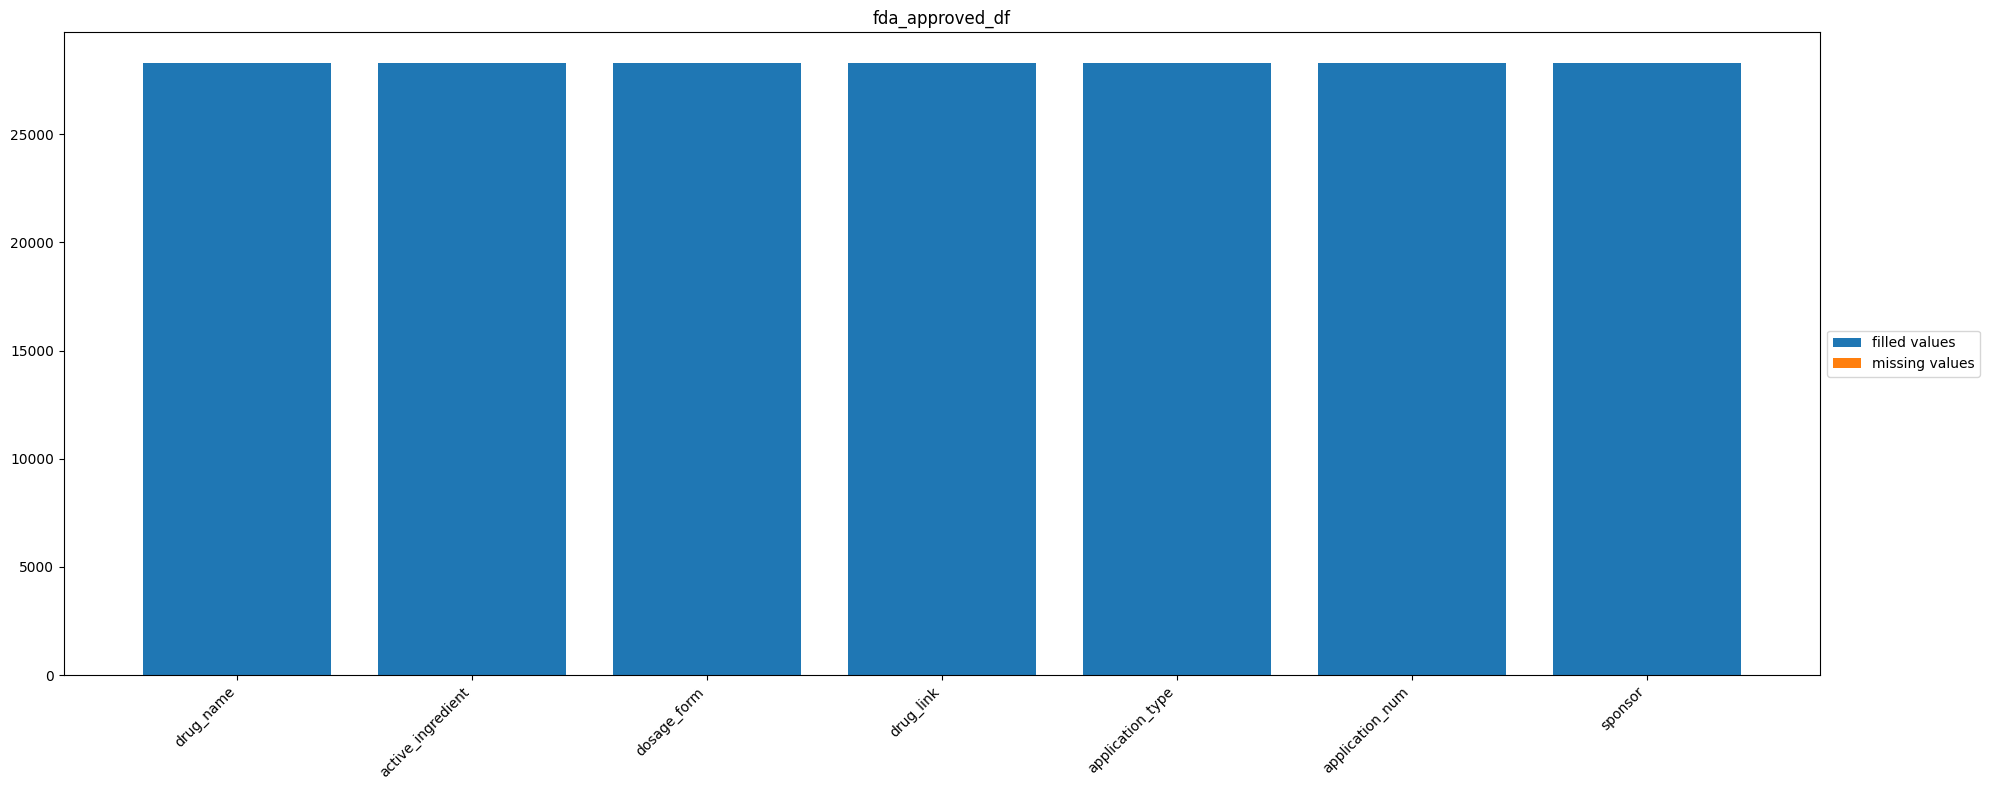

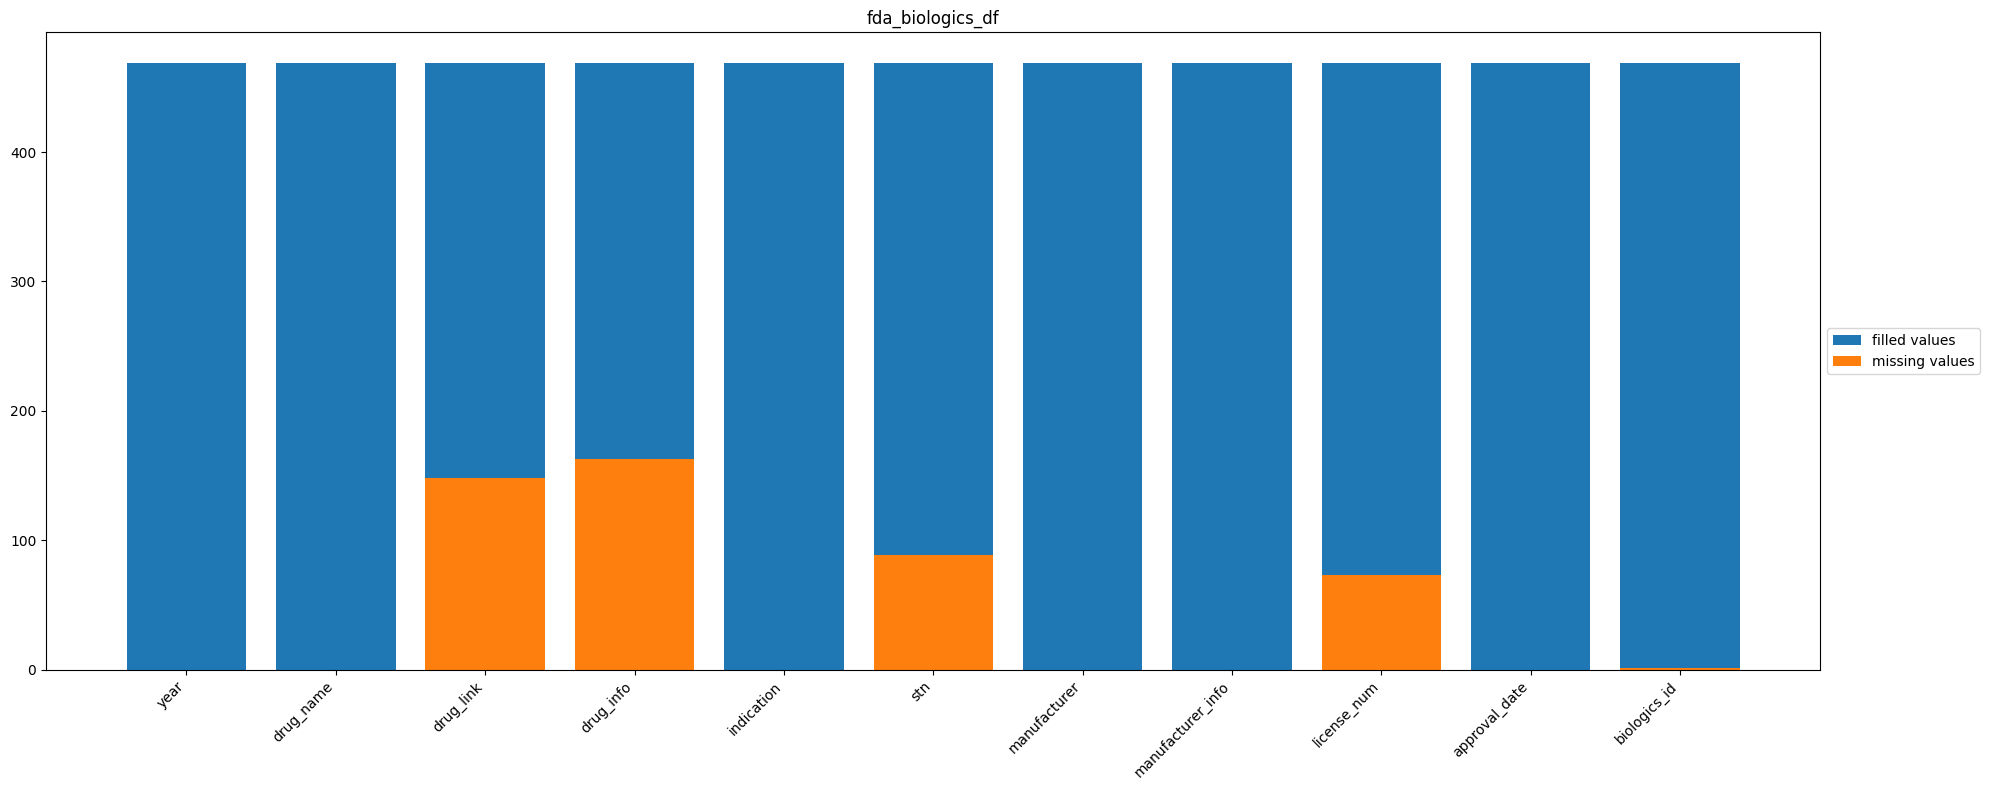

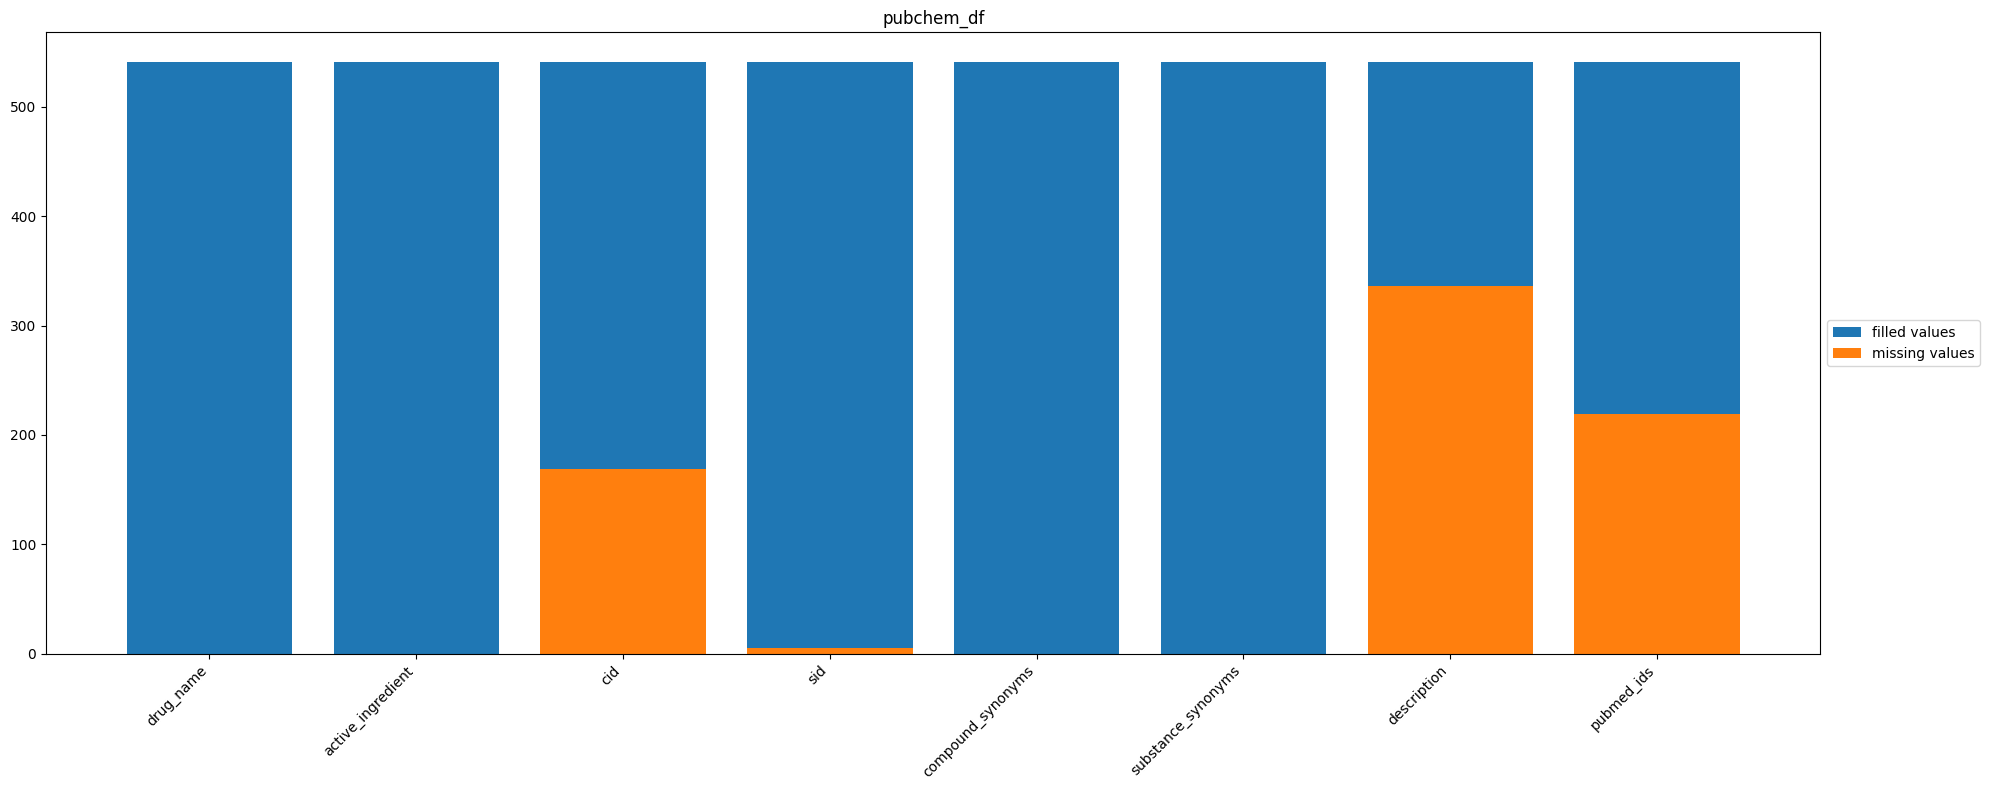

In [88]:
# for each column print the number of missing values
def plot_missing_values(df, df_name):
  vals_by_column = []
  vals_missing_by_column = []
  for col in df.columns:
    found_vals = len([field_val for field_val in df[col].tolist() if field_val])
    missing_vals = len([field_val for field_val in df[col].tolist() if (not field_val) or (field_val == 'nan')])
    # print(f'{col:<75}: {found_vals:<3} found, {missing_vals:<3} missing | total {found_vals+missing_vals}')
    vals_by_column.append(missing_vals+found_vals)
    vals_missing_by_column.append(missing_vals)

  f, ax = plt.subplots(1,1, figsize=(20,8))
  plt.bar(range(len(df.columns)), vals_by_column, label='filled values')
  plt.bar(range(len(df.columns)), vals_missing_by_column, label='missing values')
  plt.xticks(range(len(df.columns)), df.columns, rotation=45, ha='right')
  # get legend outside of plot
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.title(df_name)
  plt.tight_layout()
  plt.show()

for df_name, df in df_dict.items():
  plot_missing_values(df, df_name)

***
## BERTopic Clustering
The first clustering exercise we'll be performing is via BERTopic (documentation [link](https://github.com/MaartenGr/BERTopic)).

In [22]:
%%capture
!pip install bertopic

## Training

We start by instantiating BERTopic. We set language to `english` since our documents are in the English language. If you would like to use a multi-lingual model, please use `language="multilingual"` instead.

We will also calculate the topic probabilities. However, this can slow down BERTopic significantly at large amounts of data (>100_000 documents). It is advised to turn this off if you want to speed up the model.


In [54]:
# convert list of lists to list of strings
indication_str = []
for indication in fda_api_df['adverse_reactions'].tolist():
	if type(indication) == list:
		indication_str.append(' '.join(indication))
	else:
		indication_str.append(indication)

In [56]:
print(f'Number of characters: {len(indication_str)}')

Number of characters: 542


In [57]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(indication_str)

2024-07-25 03:05:55,163 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2024-07-25 03:06:06,850 - BERTopic - Embedding - Completed ✓
2024-07-25 03:06:06,852 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-25 03:06:09,969 - BERTopic - Dimensionality - Completed ✓
2024-07-25 03:06:09,971 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-25 03:06:10,005 - BERTopic - Cluster - Completed ✓
2024-07-25 03:06:10,010 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-25 03:06:11,077 - BERTopic - Representation - Completed ✓


## Extracting Topics
After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents. -1 refers to all outliers and should typically be ignored. Next, let's take a look at a frequent topic that were generated.

In [58]:
freq = topic_model.get_topic_info()
num_topics = len(freq['Topic'].unique())
print(f'Number of topics: {num_topics}')
freq.head(10)

Number of topics: 2


,Topic,Count,Name,Representation,Representative_Docs
0,0,529,0_in_and_of_the,"[in, and, of, the, patients, adverse, reaction...",[6 ADVERSE REACTIONS The following clinically ...
1,1,13,1_of_22_mg_duration,"[of, 22, mg, duration, mean, days, fulyzaq, da...","[, , 6 ADVERSE REACTIONS Most common adverse r..."


To see the words that most frequent each of the topics, select the topic index (from the above `Topic` column).

In [59]:
topic_index = 0 # @param {type:"integer"}
topic_model.get_topic(topic_index)  # Select the most frequent topic

[('in', 0.09503181906338026),
 ('and', 0.09384591447450465),
 ('of', 0.08659669417614013),
 ('the', 0.08077620862547143),
 ('patients', 0.06664650166629581),
 ('adverse', 0.05997295562842967),
 ('reactions', 0.05524639153939269),
 ('with', 0.05218697731515554),
 ('to', 0.051038221806302846),
 ('or', 0.03916566141850424)]

**NOTE**: BERTopic is stocastich which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

## Attributes

There are a number of attributes that you can access after having trained your BERTopic model:


| Attribute | Description |
|------------------------|---------------------------------------------------------------------------------------------|
| topics_               | The topics that are generated for each document after training or updating the topic model. |
| probabilities_ | The probabilities that are generated for each document if HDBSCAN is used. |
| topic_sizes_           | The size of each topic                                                                      |
| topic_mapper_          | A class for tracking topics and their mappings anytime they are merged/reduced.             |
| topic_representations_ | The top *n* terms per topic and their respective c-TF-IDF values.                             |
| c_tf_idf_              | The topic-term matrix as calculated through c-TF-IDF.                                       |
| topic_labels_          | The default labels for each topic.                                                          |
| custom_labels_         | Custom labels for each topic as generated through `.set_topic_labels`.                                                               |
| topic_embeddings_      | The embeddings for each topic if `embedding_model` was used.                                                              |
| representative_docs_   | The representative documents for each topic if HDBSCAN is used.                                                |

Now we want to insert the topics back into the original DataFrame, from which we can split the data in ways that allow us to observe if specific topics come more often in one group vs. the other.

In [60]:
df['topics'] = topic_model.topics_
df

,year,year_approval_count,drug_name,active_ingredient,approval_date,approved_use,drug_link,press_release,drug_trials_snapshot,nce_id,Company,Size of Company at Release,Public/Private,"modality (small molecule, antibody, bi-specific, cell therapy, etc)","pharma or biotech (""pharma"" is typically the top 10 or top 20)","if biotech, public or private","if pharma, was the asset of internal origin or acquired","if acquired, what company originated it",time since patent filed (how long did it take from IP filing to approval?),"if biotech or if originated at a biotech, how much money did that biotech raise?",how many rounds of financing did biotech raise?,who were the investors in each round of financing?,was drug first in class?,year_month,count,month,submission_type,submission_number,submission_status,submission_status_date,review_priority,submission_class_code,submission_class_code_description,application_docs,application_number,sponsor_name,brand_name,generic_name,manufacturer_name,product_ndc,product_type,route,substance_name,rxcui,spl_id,spl_set_id,package_ndc,nui,pharm_class_epc,pharm_class_cs,unii,product_number,reference_drug,active_ingredients,reference_standard,dosage_form,marketing_status,spl_product_data_elements,indications_and_usage,dosage_and_administration,dosage_forms_and_strengths,contraindications,warnings_and_cautions,adverse_reactions,adverse_reactions_table,drug_interactions,use_in_specific_populations,pregnancy,nursing_mothers,pediatric_use,geriatric_use,description,clinical_pharmacology,mechanism_of_action,pharmacodynamics,pharmacokinetics,nonclinical_toxicology,carcinogenesis_and_mutagenesis_and_impairment_of_fertility,clinical_studies,clinical_studies_table,how_supplied,information_for_patients,package_label_principal_display_panel,set_id,id,effective_time,version,is_original_packager,topics
0,2012,1,Voraxaze,glucarpidase,2012-01-17,To treat patients with toxic levels of methotr...,https://wayback.archive-it.org//7993/201610220...,https://wayback.archive-it.org///7993/20161022...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-01-01,1,1,SUPPL,20,AP,20130329,STANDARD,LABELING,Labeling,"[{'id': '18875', 'url': 'http://www.accessdata...",[BLA125327],BTG INTERNATIONAL INC,[Voraxaze],[GLUCARPIDASE],[BTG International Inc.],[50633-210],[HUMAN PRESCRIPTION DRUG],[INTRAVENOUS],[GLUCARPIDASE],"[1242131, 1242136]",[d9ab768d-1c30-4c2a-b013-91f61bc11aa0],[acaef5a6-b740-40e3-8ffe-74a75c74745c],[50633-210-11],"[N0000184013, M0003411]",[Carboxypeptidase [EPC]],[Carboxypeptidases [CS]],[2GFP9BJD79],001,No,"[{'name': 'GLUCARPIDASE', 'strength': '1000 UN...",No,INJECTABLE,Prescription,[Voraxaze glucarpidase GLUCARPIDASE GLUCARPIDA...,[1 INDICATIONS AND USAGE VORAXAZE is indicated...,[2 DOSAGE AND ADMINISTRATION The recommended d...,[3 DOSAGE FORMS AND STRENGTHS For Injection: 1...,[4 CONTRAINDICATIONS None. None.],[5 WARNINGS AND PRECAUTIONS Serious Hypersensi...,[6 ADVERSE REACTIONS The following clinically ...,"[<table ID=""table1"" width=""700""><caption>Table...",[7 DRUG INTERACTIONS 7.1 Effects of VORAXAZE o...,[8 USE IN SPECIFIC POPULATIONS 8.1 Pregnancy R...,[8.1 Pregnancy Risk Summary There are no avail...,[8.2 Lactation Risk Summary There are no data ...,[8.4 Pediatric Use The safety and effectivenes...,[8.5 Geriatric Use Of the total number of 290 ...,[11 DESCRIPTION Glucarpidase is a carboxypepti...,[12 CLINICAL PHARMACOLOGY 12.1 Mechanism of Ac...,[12.1 Mechanism of Action Glucarpidase is a re...,[12.2 Pharmacodynamics Following administratio...,[12.3 Pharmacokinetics The pharmacokinetics of...,[13 NONCLINICAL TOXICOLOGY 13.1 Carcinogenesis...,"[13.1 Carcinogenesis, Mutagenesis, Impairment ...",[14 CLINICAL STUDIES The efficacy of VORAXAZE ...,"[<table width=""750"" styleCode=""Noautorules""><c...",[16 HOW SUPPLIED/STORAGE AND HANDLING VORAXAZE...,[17 PATIENT COUNSELING INFORMATION Serious Hyp...,[Package Label - Principal Display Panel - VOR...,acaef5a6-b740-40e3-8ffe-74a75c74745c,d9ab768d-1c30-4

View the topic labels.

In [61]:
topic_model.generate_topic_labels()

['0_in_and_of', '1_of_22_mg']

To scan the output of the clustering, view the entire dataframe.

In [38]:
# display the breakdown of topics
df.groupby('topics').describe()

approval_date                                                      \
               count                           mean                  min   
topics                                                                     
0                528  2018-09-07 06:38:10.909090816  2012-01-17 00:00:00   
1                 14  2020-01-02 22:17:08.571428608  2012-08-29 00:00:00   

                                                                       \
                        25%                  50%                  75%   
topics                                                                  
0       2015-10-02 12:00:00  2018-11-12 12:00:00  2021-06-12 18:00:00   
1       2016-04-22 12:00:00  2020-04-16 12:00:00  2023-12-18 06:00:00   

                            year_month                                 \
                        max      count                           mean   
topics                                                                  
0       2024-07-02 00:00:00        528  2018-08-21 17:38:10.909090816   
1       2024-06-18 00:00:00         14  2019-12-16 10:17:08.571428608   

                                                                       \
                        min                  25%                  50%   
topics                                                                  
0       2012-01-01 00:00:00  2015-09-23 12:00:00  2018-11-01 00:00:00   
1       2012-08-01 00:00:00  2016-04-08 18:00:00  2020-04-01 00:00:00   

                                                  
                        75%                  max  
topics                                            
0       2021-06-01 00:00:00  2024-07-01 00:00:00  
1       2023-12-09 00:00:00  2024-06-01 00:00:00

***
## **Visualization**
There are several visualization options available in BERTopic, namely the visualization of topics, probabilities and topics over time. Topic modeling is, to a certain extent, quite subjective. Visualizations help understand the topics that were created.

## Visualize Topics
After having trained our `BERTopic` model, we can iteratively go through perhaps a hundred topic to get a good
understanding of the topics that were extract. However, that takes quite some time and lacks a global representation.
Instead, we can visualize the topics that were generated in a way very similar to
[LDAvis](https://github.com/cpsievert/LDAvis):

In [39]:
topic_model.visualize_topics()

ValueError: zero-size array to reduction operation maximum which has no identity

## Topic Reduction
We can also reduce the number of topics after having trained a BERTopic model. The advantage of doing so,
is that you can decide the number of topics after knowing how many are actually created. It is difficult to
predict before training your model how many topics that are in your documents and how many will be extracted.
Instead, we can decide afterwards how many topics seems realistic:





In [ ]:
topic_model.reduce_topics(df['response'].tolist(), nr_topics=10)

2023-10-25 14:52:59,031 - BERTopic - Reduced number of topics from 30 to 10


## Visualize Topic Probabilities

The variable `probabilities` that is returned from `transform()` or `fit_transform()` can
be used to understand how confident BERTopic is that certain topics can be found in a document.

To visualize the distributions, we simply call:

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.005)

## Visualize Topic Hierarchy

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

## Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [ ]:
topic_model.visualize_barchart(top_n_topics=10)

## Visualize Topic Similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [ ]:
topic_model.visualize_heatmap(n_clusters=10, width=1000, height=1000)

We can go through each topic manually, which would take a lot of work, or we can visualize them all in a single interactive graph.
BERTopic has a bunch of [visualization functions](https://medium.com/r/?url=https%3A%2F%2Fmaartengr.github.io%2FBERTopic%2Fgetting_started%2Fvisualization%2Fvisualize_documents.html) that we can use. For now, we are sticking with visualizing the documents.

In [ ]:
topic_model.visualize_documents(df['response'].tolist(), hide_annotations=True, hide_document_hover=False, custom_labels=True)

## Visualize Term Score Decline
Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, the select the best number of words in a topic.


In [ ]:
topic_model.visualize_term_rank()

## Update Topics
When you have trained a model and viewed the topics and the words that represent them,
you might not be satisfied with the representation. Perhaps you forgot to remove
stopwords or you want to try out a different `n_gram_range`. We can use the function `update_topics` to update
the topic representation with new parameters for `c-TF-IDF`:


In [ ]:
topic_model.update_topics(df['response'].tolist(), n_gram_range=(1, 2))

# **Search Topics**
After having trained our model, we can use `find_topics` to search for topics that are similar
to an input search_term. Here, we are going to be searching for topics that closely relate the
search term "vehicle". Then, we extract the most similar topic and check the results:

In [ ]:
topic_model.find_topics('guns')

([1, 17, 9, 19, 0],
 [0.8197718111191683,
  0.5489026179349554,
  0.5465478478388572,
  0.5424823538091681,
  0.53441248180827])

# **Model serialization**
The model and its internal settings can easily be saved. Note that the documents and embeddings will not be saved. However, UMAP and HDBSCAN will be saved.

In [ ]:
# Save model
topic_model.save("my_model")

In [ ]:
# Load model
my_model = BERTopic.load("my_model")

***
## Word Clouds
We can also generate word clouds for each topic, or by any specific group (wordcloud documentation [link](https://github.com/amueller/word_cloud)). You can also select all parts of speech (pos), or a specific part of speech, using the `part_of_speech` variable below. To see all pos options: [TextBlob docs](https://www.geeksforgeeks.org/python-part-of-speech-tagging-using-textblob/). <br>

Additionally, if you want to exclude words from any of the WordClouds, include as a LOWER-CASE csv-delimited string in the `exclude_words` variable, as an example:
```
exclude_words: "liberal, conservative"
```

We will also be lemmatizing each of the words to reduce redundancy. For more info on lemmatizing: [NLTK Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/).

Excluded Words
  liberal
  liberals
  conservative
  conservatives


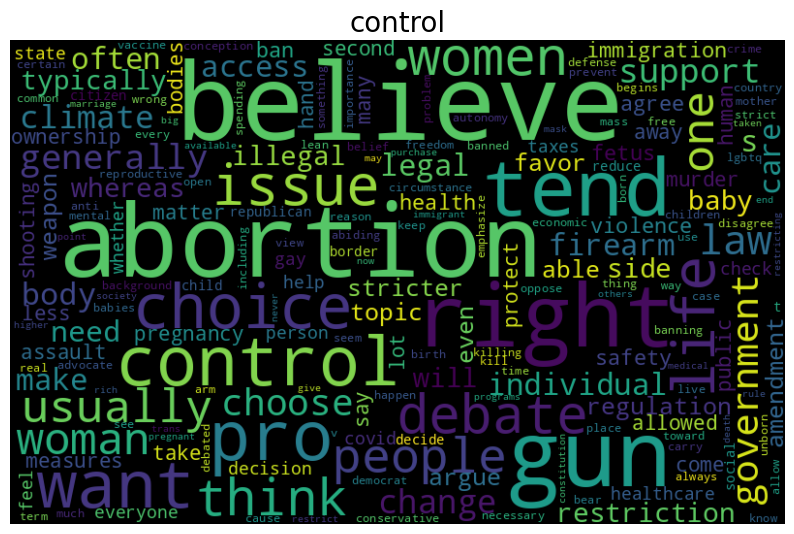

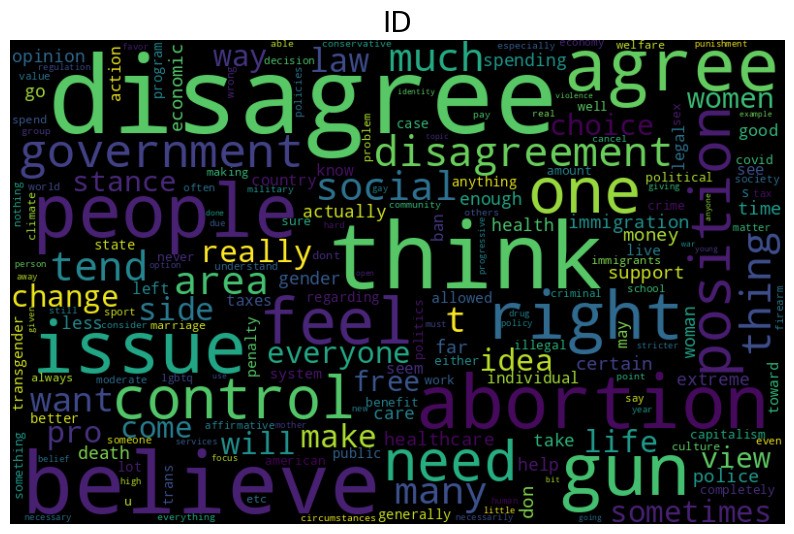

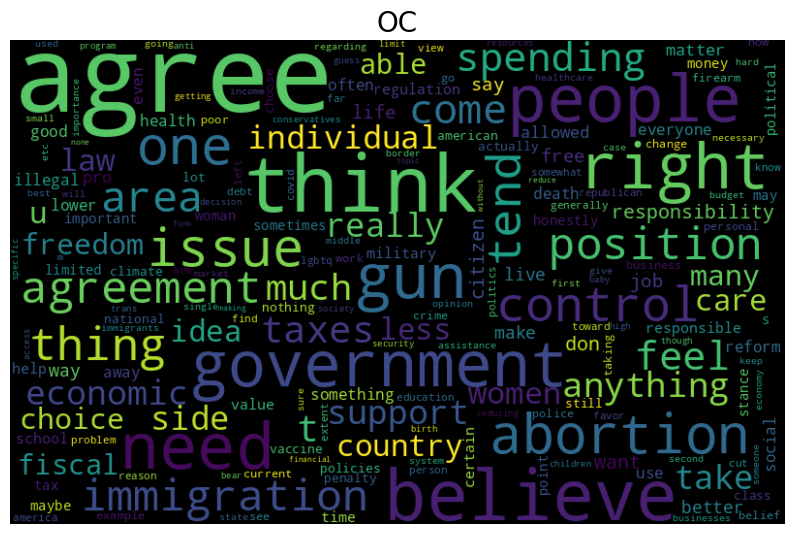

In [ ]:
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer

def symbol_remover(word):
    '''
    symbol_remover replaces symbols with spaces
    '''
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for symbol in symbols:
        word = np.char.replace(word, symbol, ' ')
        word = np.char.replace(word, "'", "")
    return(str(word))

# Generate a word cloud for each topic
def generate_wordcloud(df, label, excluded_words_list=None, lemmatizer=None):

  # Convert the responses to a single string
  all_responses = ' '.join(df['response'].values)
  # Select only words_in_pos
  part_of_speech = "ALL" # @param ["ALL", "NN", "NNS", "JJ", "VB"] {allow-input: true}

  if part_of_speech != "ALL":
    words_in_pos = [lemmatizer.lemmatize(word.lower().strip()) for word, tag in TextBlob(all_responses).pos_tags if tag == part_of_speech \
                    and lemmatizer.lemmatize(symbol_remover(word).lower().strip()) not in excluded_words_list]
  else:
    words_in_pos = [word.lower().strip() for word in all_responses.split() if lemmatizer.lemmatize(symbol_remover(word).lower().strip()) not in excluded_words_list]
  all_responses_cleaned = ' '.join(words_in_pos)
  # Create the word cloud
  wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110, collocations=False, stopwords=None).generate(all_responses_cleaned)
  # Display the word cloud
  plt.figure(figsize=(10, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.title(f'{label}', fontsize=20)
  plt.show()

exclude_words = "liberal, liberals, conservative, conservatives" # @param {type:"string"}
lemmatizer = WordNetLemmatizer()
excluded_words_list = exclude_words.split(', ')
print(f'Excluded Words')
for excluded_word in excluded_words_list:
  print(f'  {excluded_word}')

for group in df[column_of_interest].unique():
  df_group = df[df[column_of_interest] == group]
  generate_wordcloud(df_group, group, excluded_words_list, lemmatizer)

In [ ]:
def word_count_search(df):
    '''
    word_counter takes in user-inputted word
    and compares all the usage of that word
    across all members of the chat
    '''
    wordSelect = input('What word are you looking to compare?').lower()
    wordUser = defaultdict(list)
    # for significance test
    for m_index, message in enumerate(df['response']):
        message_cleaned = message.lower()
        sender = str(df[column_of_interest].iloc[m_index])
        if wordSelect in message_cleaned:
            wordUser[sender].append(1)
        else:
            wordUser[sender].append(0)
    print(f'Word: {wordSelect}')
    frequencies = []
    groups = wordUser.keys()
    values_list = wordUser.values()
    for name in wordUser.keys():
        df_len = len(df[df[column_of_interest] == name])
        freq = round(np.mean(wordUser[name]), 4)
        print(f'  Frequency used by {name}: {freq} ({np.sum(wordUser[name])})')


    group_combinations = list(combinations(groups, 2))
    values_combinations = list(combinations(values_list, 2))
    ks_test_group(group_combinations, values_combinations)

word_count_search(df)

What word are you looking to compare?abortion
Word: abortion
  Frequency used by control: 0.4482 (281)
  Frequency used by ID: 0.1076 (68)
  Frequency used by OC: 0.0784 (49)
  control vs ID: ks_stat: 0.34, p_val: 7.35E-33
  control vs OC: ks_stat: 0.37, p_val: 1.22E-38
  ID vs OC: ks_stat: 0.03, p_val: 9.41E-01


In [ ]:
# import stopwords
from nltk.corpus import stopwords

def token_cleaner(df):
    '''
    token_cleaner removes unnecessary words (e.g. and, the, what)
    for future analyses. I could have done it earlier, but I thought
    maybe, for whatever reason, if anyone would be interested in
    how often either of use any of these words, it would be you.
    '''
    allWords = defaultdict(list)
    stopWords = stopwords.words('english')
    m_index = 0
    for m_index, message in enumerate(df['response']):
        sender = df[column_of_interest].iloc[m_index]
        message_cleaned = message.lower()
        for word in message_cleaned.split(' '):
            if word not in stopWords:
                word = symbol_remover(word)
                if len(word) < 1:
                    continue
                allWords[sender].append(word)
        m_index += 1
    return(allWords)

# allWords is not a dictionary with presumably only meaningful words
allWords = token_cleaner(df)

## WIP

Streaming output truncated to the last 5000 lines.
ID lgbtq 0.0008793969849246232
ID use 0.0007537688442211055
ID using 0.0007537688442211055
ID identity 0.0007537688442211055
ID letting 0.0007537688442211055
ID individuals 0.0007537688442211055
ID compete 0.0007537688442211055
ID long 0.0007537688442211055
ID sort 0.0007537688442211055
ID military 0.0007537688442211055
ID mental 0.0007537688442211055
ID progressive 0.0007537688442211055
ID look 0.0007537688442211055
ID live 0.0007537688442211055
ID restrictions 0.0007537688442211055
ID importance 0.0007537688442211055
ID police  0.0007537688442211055
ID try 0.0007537688442211055
ID society 0.0007537688442211055
ID sports 0.0007537688442211055
ID capitalism 0.0007537688442211055
ID laws  0.0007537688442211055
ID areas 0.0007537688442211055
ID covid 0.0007537688442211055
ID toward 0.0007537688442211055
ID moderate 0.0007537688442211055
ID rather 0.0007537688442211055
ID community 0.0007537688442211055
ID justice 0.0007537688442211055
ID

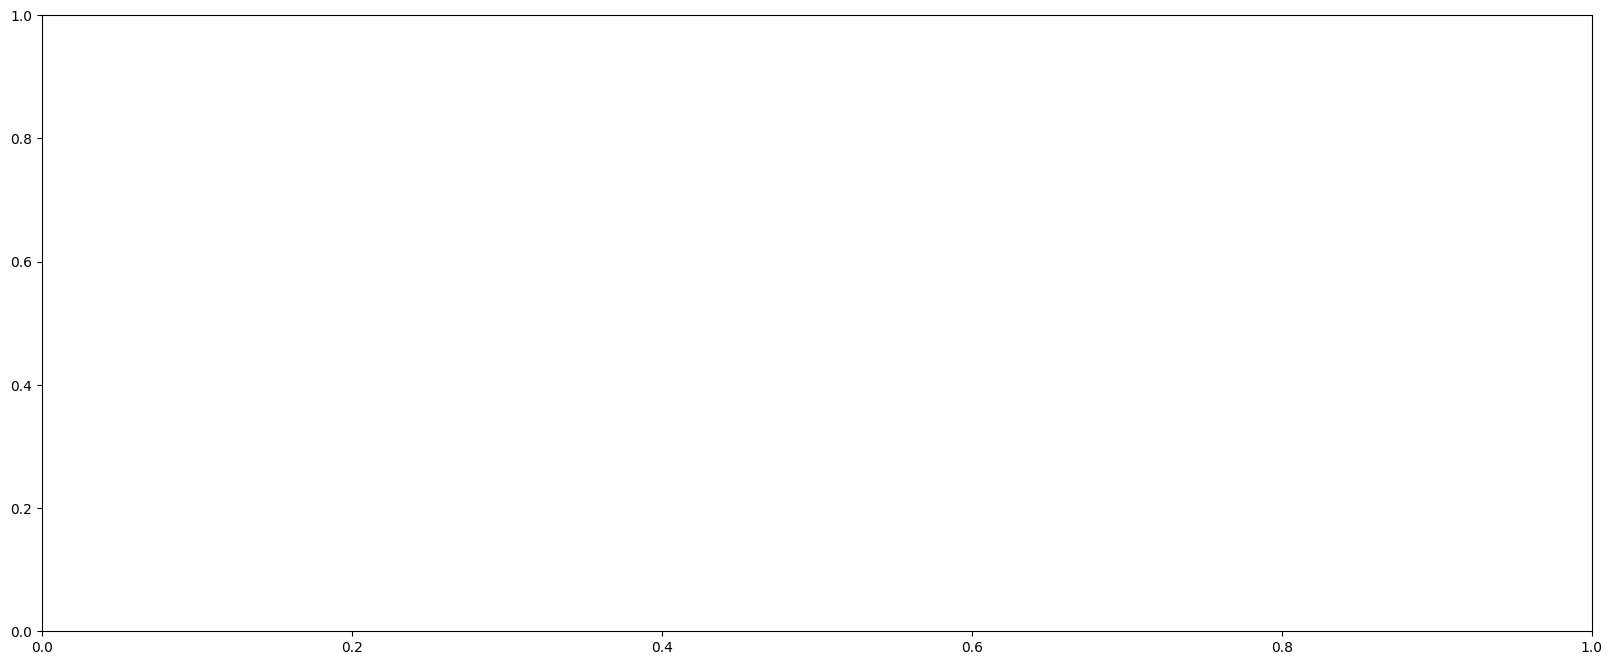

In [ ]:
from nltk.probability import FreqDist
from collections import Counter, OrderedDict

def words_plotter(NUM_OF_WORDS, word_count_groups):
    '''
    words_plotter plots the usage of top words, by user
    '''
    x = np.arange(NUM_OF_WORDS)
    f, ax = plt.subplots(1, figsize=(20,8))
    width = 0.3

    groups = word_count_groups.keys()
    instances_of_words = []
    for group in groups:
      top_n_words = word_count_groups[group].keys()
      for word in top_n_words:
        instances_of_words.append(word_count_groups[group][word])
        print(group, word, word_count_groups[group][word])
    # plt.bar(x, word_count_group, width=width, ec='black')

    # ax.set_xticks(x+width/2)
    # ax.set_xticklabels(words, rotation=45)
    # plt.title('Ordered by ' + user + '\'s Top Words')
    # plt.xlabel('Word')
    # plt.ylabel('Frequency of Word')
    # plt.legend()
    # plt.show()

def top_words_by_group(num_top_words):
    '''
    top_words_by_group analyzes the top words used by each user
    and compares the volume differences by each
    '''
    word_count_groups = defaultdict(lambda: defaultdict(float))
    for group in df[column_of_interest].unique():
      fdist_group = Counter(dict(FreqDist(allWords[group])))

      wordsOrdered_hash_group = OrderedDict(sorted(fdist_group.items(),
                                      reverse=True, key=lambda t: t[1]))

      # total number of words in each corpus to normalize
      total_words_group = sum(wordsOrdered_hash_group.values())
      for word in wordsOrdered_hash_group.keys():
        word_count_groups[group][word] = wordsOrdered_hash_group[word]/total_words_group

    words_plotter(NUM_OF_WORDS, word_count_groups)

NUM_OF_WORDS = 30
top_words_by_group(NUM_OF_WORDS)